# Basic Functionality

**Prerequisites**

- {doc}`pandas Intro <intro>`

**Outcomes**

- Be familiar with `datetime`
- Use built-in aggregation functions and be able to create your own and
  apply them using `agg`
- Use built-in Series transformation functions and be able to create your
  own and apply them using `apply`
- Use built-in scalar transformation functions and be able to create your
  own and apply them using `applymap`
- Be able to select subsets of the DataFrame using boolean selection
- Know what the "want operator" is and how to apply it

**Data**

- US state unemployment data from Bureau of Labor Statistics


```{literalinclude} ../_static/colab_light.raw
```

## State Unemployment Data

In this lecture, we will use unemployment data by state at a monthly
frequency.

In [1]:
import pandas as pd

%matplotlib inline

pd.__version__

'1.3.0'

First, we will download the data directly from a url and read it into a pandas DataFrame.

In [2]:
## Load up the data -- this will take a couple seconds
url = "https://datascience.quantecon.org/assets/data/state_unemployment.csv"
unemp_raw = pd.read_csv(url, parse_dates=["Date"])

The pandas `read_csv` will determine most datatypes of the underlying columns.  The
exception here is that we need to give pandas a hint so it can load up the `Date` column as a Python datetime type: the `parse_dates=["Date"]`.

We can see the basic structure of the downloaded data by getting the first 5 rows, which directly matches
the underlying CSV file.

In [3]:
unemp_raw.head()

,Date,state,LaborForce,UnemploymentRate
0,2000-01-01,Alabama,2142945.0,4.7
1,2000-01-01,Alaska,319059.0,6.3
2,2000-01-01,Arizona,2499980.0,4.1
3,2000-01-01,Arkansas,1264619.0,4.4
4,2000-01-01,California,16680246.0,5.0


Note that a row has a date, state, labor force size, and unemployment rate.

For our analysis, we want to look at the unemployment rate across different states over time, which
requires a transformation of the data similar to an Excel pivot-table.

In [4]:
# Don't worry about the details here quite yet
unemp_all = (
    unemp_raw
    .reset_index()
    .pivot_table(index="Date", columns="state", values="UnemploymentRate")
)
unemp_all.head()

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,4.7,6.3,4.1,4.4,5.0,2.8,2.8,3.5,3.7,3.7,...,2.4,3.7,4.6,3.1,2.7,2.6,4.9,5.8,3.2,4.1
2000-02-01,4.7,6.3,4.1,4.3,5.0,2.8,2.7,3.6,3.7,3.6,...,2.4,3.7,4.6,3.1,2.6,2.5,4.9,5.6,3.2,3.9
2000-03-01,4.6,6.3,4.0,4.3,5.0,2.7,2.6,3.6,3.7,3.6,...,2.4,3.8,4.5,3.1,2.6,2.4,5.0,5.5,3.3,3.9
2000-04-01,4.6,6.3,4.0,4.3,5.1,2.7,2.5,3.7,3.7,3.7,...,2.4,3.8,4.4,3.1,2.7,2.4,5.0,5.4,3.4,3.8
2000-05-01,4.5,6.3,4.0,4.2,5.1,2.7,2.4,3.7,3.7,3.7,...,2.4,3.9,4.3,3.2,2.7,2.3,5.1,5.4,3.5,3.8


Finally, we can filter it to look at a subset of the columns (i.e. "state" in this case).

In [5]:
states = [
    "Arizona", "California", "Florida", "Illinois",
    "Michigan", "New York", "Texas"
]
unemp = unemp_all[states]
unemp.head()

state,Arizona,California,Florida,Illinois,Michigan,New York,Texas
Date,,,,,,,
2000-01-01,4.1,5.0,3.7,4.2,3.3,4.7,4.6
2000-02-01,4.1,5.0,3.7,4.2,3.2,4.7,4.6
2000-03-01,4.0,5.0,3.7,4.3,3.2,4.6,4.5
2000-04-01,4.0,5.1,3.7,4.3,3.3,4.6,4.4
2000-05-01,4.0,5.1,3.7,4.3,3.5,4.6,4.3


When plotting, a DataFrame knows the column and index names.

<AxesSubplot:xlabel='Date'>

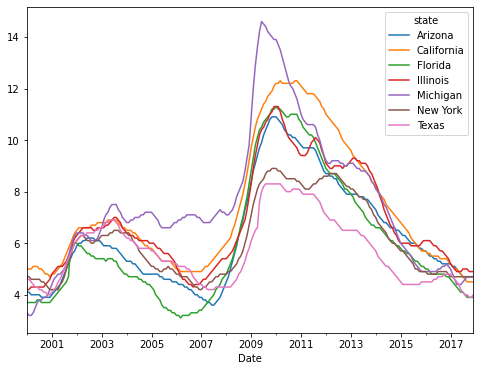

In [6]:
unemp.plot(figsize=(8, 6))

````{admonition} Exercise
:name: pd-bas-dir1
See exercise 1 in the {ref}`exercise list <pd-bas-ex>`.
````

## Dates in pandas

You might have noticed that our index now has a nice format for the
dates (`YYYY-MM-DD`) rather than just a year.

This is because the `dtype` of the index is a variant of `datetime`.

In [7]:
unemp.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01',
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', name='Date', length=216, freq=None)

We can index into a DataFrame with a `DatetimeIndex` using string
representations of dates.

For example

In [8]:
# Data corresponding to a single date
unemp.loc["01/01/2000", :]

state
Arizona       4.1
California    5.0
Florida       3.7
Illinois      4.2
Michigan      3.3
New York      4.7
Texas         4.6
Name: 2000-01-01 00:00:00, dtype: float64

In [9]:
# Data for all days between New Years Day and June first in the year 2000
unemp.loc["01/01/2000":"06/01/2000", :]

state,Arizona,California,Florida,Illinois,Michigan,New York,Texas
Date,,,,,,,
2000-01-01,4.1,5.0,3.7,4.2,3.3,4.7,4.6
2000-02-01,4.1,5.0,3.7,4.2,3.2,4.7,4.6
2000-03-01,4.0,5.0,3.7,4.3,3.2,4.6,4.5
2000-04-01,4.0,5.1,3.7,4.3,3.3,4.6,4.4
2000-05-01,4.0,5.1,3.7,4.3,3.5,4.6,4.3
2000-06-01,4.0,5.1,3.8,4.3,3.7,4.6,4.3


We will learn more about what pandas can do with dates and times in an
upcoming lecture on time series data.

## DataFrame Aggregations

Let's talk about *aggregations*.

Loosely speaking, an aggregation is an operation that combines multiple
values into a single value.

For example, computing the mean of three numbers (for example
`[0, 1, 2]`) returns a single number (1).

We will use aggregations extensively as we analyze and manipulate our data.

Thankfully, pandas makes this easy!

### Built-in Aggregations

pandas already has some of the most frequently used aggregations.

For example:

- Mean  (`mean`)
- Variance (`var`)
- Standard deviation (`std`)
- Minimum (`min`)
- Median (`median`)
- Maximum (`max`)
- etc...

```{note}
When looking for common operations, using "tab completion" goes a long way.
```

In [10]:
unemp.mean()

state
Arizona       6.301389
California    7.299074
Florida       6.048611
Illinois      6.822685
Michigan      7.492593
New York      6.102315
Texas         5.695370
dtype: float64

As seen above, the aggregation's default is to aggregate each column.

However, by using the `axis` keyword argument, you can do aggregations by
row as well.

In [11]:
unemp.var(axis=1).head()

Date
2000-01-01    0.352381
2000-02-01    0.384762
2000-03-01    0.364762
2000-04-01    0.353333
2000-05-01    0.294762
dtype: float64

### Writing Your Own Aggregation

The built-in aggregations will get us pretty far in our analysis, but
sometimes we need more flexibility.

We can have pandas perform custom aggregations by following these two
steps:

1. Write a Python function that takes a `Series` as an input and
   outputs a single value.
1. Call the `agg` method with our new function as an argument.

For example, below, we will classify states as "low unemployment" or
"high unemployment" based on whether their mean unemployment level is
above or below 6.5.

In [12]:
#
# Step 1: We write the (aggregation) function that we'd like to use
#
def high_or_low(s):
    """
    This function takes a pandas Series object and returns high
    if the mean is above 6.5 and low if the mean is below 6.5
    """
    if s.mean() < 6.5:
        out = "Low"
    else:
        out = "High"

    return out

In [13]:
#
# Step 2: Apply it via the agg method.
#
unemp.agg(high_or_low)

state
Arizona        Low
California    High
Florida        Low
Illinois      High
Michigan      High
New York       Low
Texas          Low
dtype: object

In [14]:
# How does this differ from unemp.agg(high_or_low)?
unemp.agg(high_or_low, axis=1).head()

Date
2000-01-01    Low
2000-02-01    Low
2000-03-01    Low
2000-04-01    Low
2000-05-01    Low
dtype: object

Notice that `agg` can also accept multiple functions at once.

In [15]:
unemp.agg([min, max, high_or_low])

state,Arizona,California,Florida,Illinois,Michigan,New York,Texas
min,3.6,4.5,3.1,4.2,3.2,4.2,3.9
max,10.9,12.3,11.3,11.3,14.6,8.9,8.3
high_or_low,Low,High,Low,High,High,Low,Low


````{admonition} Exercise
:name: pd-bas-dir2
See exercise 2 in the {ref}`exercise list <pd-bas-ex>`.
````

## Transforms

Many analytical operations do not necessarily involve an aggregation.

The output of a function applied to a Series might need to be a new
Series.

Some examples:

- Compute the percentage change in unemployment from month to month.
- Calculate the cumulative sum of elements in each column.

### Built-in Transforms

pandas comes with many transform functions including:

- Cumulative sum/max/min/product (`cum(sum|min|max|prod)`)
- Difference  (`diff`)
- Elementwise addition/subtraction/multiplication/division (`+`, `-`, `*`, `/`)
- Percent change (`pct_change`)
- Number of occurrences of each distinct value (`value_counts`)
- Absolute value (`abs`)

Again, tab completion is helpful when trying to find these functions.

In [16]:
unemp.head()

state,Arizona,California,Florida,Illinois,Michigan,New York,Texas
Date,,,,,,,
2000-01-01,4.1,5.0,3.7,4.2,3.3,4.7,4.6
2000-02-01,4.1,5.0,3.7,4.2,3.2,4.7,4.6
2000-03-01,4.0,5.0,3.7,4.3,3.2,4.6,4.5
2000-04-01,4.0,5.1,3.7,4.3,3.3,4.6,4.4
2000-05-01,4.0,5.1,3.7,4.3,3.5,4.6,4.3


In [17]:
unemp.pct_change(fill_method = None).head() # Skip calculation for missing data

state,Arizona,California,Florida,Illinois,Michigan,New York,Texas
Date,,,,,,,
2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,0.00000,0.00,0.0,0.00000,-0.030303,0.000000,0.000000
2000-03-01,-0.02439,0.00,0.0,0.02381,0.000000,-0.021277,-0.021739
2000-04-01,0.00000,0.02,0.0,0.00000,0.031250,0.000000,-0.022222
2000-05-01,0.00000,0.00,0.0,0.00000,0.060606,0.000000,-0.022727


In [18]:
unemp.diff().head()

state,Arizona,California,Florida,Illinois,Michigan,New York,Texas
Date,,,,,,,
2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,0.0,0.0,0.0,0.0,-0.1,0.0,0.0
2000-03-01,-0.1,0.0,0.0,0.1,0.0,-0.1,-0.1
2000-04-01,0.0,0.1,0.0,0.0,0.1,0.0,-0.1
2000-05-01,0.0,0.0,0.0,0.0,0.2,0.0,-0.1


Transforms can be split into to several main categories:

1. *Series transforms*: functions that take in one Series and produce another Series. The index of the input and output does not need to be the same.
1. *Scalar transforms*: functions that take a single value and produce a single value. An example is the `abs` method, or adding a constant to each value of a Series.

### Custom Series Transforms

pandas also simplifies applying custom Series transforms to a Series or the
columns of a DataFrame. The steps are:

1. Write a Python function that takes a Series and outputs a new Series.
1. Pass our new function as an argument to the `apply` method (alternatively, the `transform` method).

As an example, we will standardize our unemployment data to have mean 0
and standard deviation 1.

After doing this, we can use an aggregation to determine at which date the
unemployment rate is most different from "normal times" for each state.

In [19]:
#
# Step 1: We write the Series transform function that we'd like to use
#
def standardize_data(x):
    """
    Changes the data in a Series to become mean 0 with standard deviation 1
    """
    mu = x.mean()
    std = x.std()

    return (x - mu)/std

In [20]:
#
# Step 2: Apply our function via the apply method.
#
std_unemp = unemp.apply(standardize_data)
std_unemp.head()

state,Arizona,California,Florida,Illinois,Michigan,New York,Texas
Date,,,,,,,
2000-01-01,-1.076861,-0.935545,-0.976846,-1.337203,-1.605740,-0.925962,-0.849345
2000-02-01,-1.076861,-0.935545,-0.976846,-1.337203,-1.644039,-0.925962,-0.849345
2000-03-01,-1.125778,-0.935545,-0.976846,-1.286217,-1.644039,-0.991993,-0.926885
2000-04-01,-1.125778,-0.894853,-0.976846,-1.286217,-1.605740,-0.991993,-1.004424
2000-05-01,-1.125778,-0.894853,-0.976846,-1.286217,-1.529141,-0.991993,-1.081964


In [21]:
# Takes the absolute value of all elements of a function
abs_std_unemp = std_unemp.abs()

abs_std_unemp.head()

state,Arizona,California,Florida,Illinois,Michigan,New York,Texas
Date,,,,,,,
2000-01-01,1.076861,0.935545,0.976846,1.337203,1.605740,0.925962,0.849345
2000-02-01,1.076861,0.935545,0.976846,1.337203,1.644039,0.925962,0.849345
2000-03-01,1.125778,0.935545,0.976846,1.286217,1.644039,0.991993,0.926885
2000-04-01,1.125778,0.894853,0.976846,1.286217,1.605740,0.991993,1.004424
2000-05-01,1.125778,0.894853,0.976846,1.286217,1.529141,0.991993,1.081964


In [22]:
# find the date when unemployment was "most different from normal" for each State
def idxmax(x):
    # idxmax of Series will return index of maximal value
    return x.idxmax()

abs_std_unemp.agg(idxmax)

state
Arizona      2009-11-01
California   2010-03-01
Florida      2010-01-01
Illinois     2009-12-01
Michigan     2009-06-01
New York     2009-11-01
Texas        2009-08-01
dtype: datetime64[ns]

### Custom Scalar Transforms

As you may have predicted, we can also apply custom scalar transforms to our
pandas data.

To do this, we use the following pattern:

1. Define a Python function that takes in a scalar and produces a scalar.
1. Pass this function as an argument to the `applymap` Series or DataFrame method.

Complete the exercise below to practice writing and using your own scalar
transforms.

````{admonition} Exercise
:name: pd-bas-dir3
See exercise 3 in the {ref}`exercise list <pd-bas-ex>`.
````

## Boolean Selection

We have seen how we can select subsets of data by referring to the index
or column names.

However, we often want to select based on conditions met by
the data itself.

Some examples are:

- Restrict analysis to all individuals older than 18.
- Look at data that corresponds to particular time periods.
- Analyze only data that corresponds to a recession.
- Obtain data for a specific product or customer ID.

We will be able to do this by using a Series or list of boolean values
to index into a Series or DataFrame.

Let's look at some examples.

In [23]:
unemp_small = unemp.head()  # Create smaller data so we can see what's happening
unemp_small

state,Arizona,California,Florida,Illinois,Michigan,New York,Texas
Date,,,,,,,
2000-01-01,4.1,5.0,3.7,4.2,3.3,4.7,4.6
2000-02-01,4.1,5.0,3.7,4.2,3.2,4.7,4.6
2000-03-01,4.0,5.0,3.7,4.3,3.2,4.6,4.5
2000-04-01,4.0,5.1,3.7,4.3,3.3,4.6,4.4
2000-05-01,4.0,5.1,3.7,4.3,3.5,4.6,4.3


In [24]:
# list of booleans selects rows
unemp_small.loc[[True, True, True, False, False]]

state,Arizona,California,Florida,Illinois,Michigan,New York,Texas
Date,,,,,,,
2000-01-01,4.1,5.0,3.7,4.2,3.3,4.7,4.6
2000-02-01,4.1,5.0,3.7,4.2,3.2,4.7,4.6
2000-03-01,4.0,5.0,3.7,4.3,3.2,4.6,4.5


In [25]:
# second argument selects columns, the  ``:``  means "all".
# here we use it to select all columns
unemp_small.loc[[True, False, True, False, True], :]

state,Arizona,California,Florida,Illinois,Michigan,New York,Texas
Date,,,,,,,
2000-01-01,4.1,5.0,3.7,4.2,3.3,4.7,4.6
2000-03-01,4.0,5.0,3.7,4.3,3.2,4.6,4.5
2000-05-01,4.0,5.1,3.7,4.3,3.5,4.6,4.3


In [26]:
# can use booleans to select both rows and columns
unemp_small.loc[[True, True, True, False, False], [True, False, False, False, False, True, True]]

state,Arizona,New York,Texas
Date,,,
2000-01-01,4.1,4.7,4.6
2000-02-01,4.1,4.7,4.6
2000-03-01,4.0,4.6,4.5


### Creating Boolean DataFrames/Series

We can use {doc}`conditional statements <../python_fundamentals/control_flow>` to
construct Series of booleans from our data.

In [27]:
unemp_small["Texas"] < 4.5

Date
2000-01-01    False
2000-02-01    False
2000-03-01    False
2000-04-01     True
2000-05-01     True
Name: Texas, dtype: bool

Once we have our Series of bools, we can use it to extract subsets of
rows from our DataFrame.

In [28]:
unemp_small.loc[unemp_small["Texas"] < 4.5]

state,Arizona,California,Florida,Illinois,Michigan,New York,Texas
Date,,,,,,,
2000-04-01,4.0,5.1,3.7,4.3,3.3,4.6,4.4
2000-05-01,4.0,5.1,3.7,4.3,3.5,4.6,4.3


In [29]:
unemp_small["New York"] > unemp_small["Texas"]

Date
2000-01-01    True
2000-02-01    True
2000-03-01    True
2000-04-01    True
2000-05-01    True
dtype: bool

In [30]:
big_NY = unemp_small["New York"] > unemp_small["Texas"]
unemp_small.loc[big_NY]

state,Arizona,California,Florida,Illinois,Michigan,New York,Texas
Date,,,,,,,
2000-01-01,4.1,5.0,3.7,4.2,3.3,4.7,4.6
2000-02-01,4.1,5.0,3.7,4.2,3.2,4.7,4.6
2000-03-01,4.0,5.0,3.7,4.3,3.2,4.6,4.5
2000-04-01,4.0,5.1,3.7,4.3,3.3,4.6,4.4
2000-05-01,4.0,5.1,3.7,4.3,3.5,4.6,4.3


#### Multiple Conditions

In the boolean section of the {doc}`basics lecture <../python_fundamentals/basics>`, we saw
that we can use the words `and` and `or` to combine multiple booleans into
a single bool.

Recall:

- `True and False -> False`
- `True and True -> True`
- `False and False -> False`
- `True or False -> True`
- `True or True -> True`
- `False or False -> False`

We can do something similar in pandas, but instead of
`bool1 and bool2` we write:

```{code-block} python
(bool_series1) & (bool_series2)
```

Likewise, instead of `bool1 or bool2` we write:

```{code-block} python
(bool_series1) | (bool_series2)
```

In [31]:
small_NYTX = (unemp_small["Texas"] < 4.7) & (unemp_small["New York"] < 4.7)
small_NYTX

Date
2000-01-01    False
2000-02-01    False
2000-03-01     True
2000-04-01     True
2000-05-01     True
dtype: bool

In [32]:
unemp_small[small_NYTX]

state,Arizona,California,Florida,Illinois,Michigan,New York,Texas
Date,,,,,,,
2000-03-01,4.0,5.0,3.7,4.3,3.2,4.6,4.5
2000-04-01,4.0,5.1,3.7,4.3,3.3,4.6,4.4
2000-05-01,4.0,5.1,3.7,4.3,3.5,4.6,4.3


#### `isin`

Sometimes, we will want to check whether a data point takes on one of a
several fixed values.

We could do this by writing `(df["x"] == val_1) | (df["x"] == val_2)`
(like we did above), but there is a better way: the `.isin` method

In [33]:
unemp_small["Michigan"].isin([3.3, 3.2])

Date
2000-01-01     True
2000-02-01     True
2000-03-01     True
2000-04-01     True
2000-05-01    False
Name: Michigan, dtype: bool

In [34]:
# now select full rows where this Series is True
unemp_small.loc[unemp_small["Michigan"].isin([3.3, 3.2])]

state,Arizona,California,Florida,Illinois,Michigan,New York,Texas
Date,,,,,,,
2000-01-01,4.1,5.0,3.7,4.2,3.3,4.7,4.6
2000-02-01,4.1,5.0,3.7,4.2,3.2,4.7,4.6
2000-03-01,4.0,5.0,3.7,4.3,3.2,4.6,4.5
2000-04-01,4.0,5.1,3.7,4.3,3.3,4.6,4.4


#### `.any` and `.all`

Recall from the boolean section of the {doc}`basics lecture <../python_fundamentals/basics>`
that the Python functions `any` and `all` are aggregation functions that
take a collection of booleans and return a single boolean.

`any` returns True whenever at least one of the inputs are True while
`all` is True only when all the inputs are `True`.

Series and DataFrames with `dtype` bool have `.any` and `.all`
methods that apply this logic to pandas objects.

Let's use these methods to count how many months all the states in our
sample had high unemployment.

As we work through this example, consider the ["want
operator"](http://albertjmenkveld.com/2014/07/07/endogeneous-price-dispersion/), a helpful
concept from Nobel Laureate [Tom
Sargent](http://www.tomsargent.com) for clearly stating the goal of our analysis and
determining the steps necessary to reach the goal.

We always begin by writing `Want:` followed by what we want to
accomplish.

In this case, we would write:

> Want: Count the number of months in which all states in our sample
> had unemployment above 6.5%

After identifying the **want**, we work *backwards* to identify the
steps necessary to accomplish our goal.

So, starting from the result, we have:

1. Sum the number of `True` values in a Series indicating dates for
   which all states had high unemployment.
1. Build the Series used in the last step by using the `.all` method
   on a DataFrame containing booleans indicating whether each state had
   high unemployment at each date.
1. Build the DataFrame used in the previous step using a `>`
   comparison.

Now that we have a clear plan, let's follow through and *apply* the want
operator:

In [35]:
# Step 3: construct the DataFrame of bools
high = unemp > 6.5
high.head()

state,Arizona,California,Florida,Illinois,Michigan,New York,Texas
Date,,,,,,,
2000-01-01,False,False,False,False,False,False,False
2000-02-01,False,False,False,False,False,False,False
2000-03-01,False,False,False,False,False,False,False
2000-04-01,False,False,False,False,False,False,False
2000-05-01,False,False,False,False,False,False,False


In [36]:
# Step 2: use the .all method on axis=1 to get the dates where all states have a True
all_high = high.all(axis=1)
all_high.head()

Date
2000-01-01    False
2000-02-01    False
2000-03-01    False
2000-04-01    False
2000-05-01    False
dtype: bool

In [37]:
# Step 1: Call .sum to add up the number of True values in `all_high`
#         (note that True == 1 and False == 0 in Python, so .sum will count Trues)
msg = "Out of {} months, {} had high unemployment across all states"
print(msg.format(len(all_high), all_high.sum()))

Out of 216 months, 41 had high unemployment across all states


````{admonition} Exercise
:name: pd-bas-dir4
See exercise 4 in the {ref}`exercise list <pd-bas-ex>`.
````

(pd-bas-ex)=
## Exercises

### Exercise 1

Looking at the displayed DataFrame above, can you identify the index? The columns?

You can use the cell below to verify your visual intuition.

In [38]:
# your code here

({ref}`back to text <pd-bas-dir1>`)

### Exercise 2

Do the following exercises in separate code cells below:

- At each date, what is the minimum unemployment rate across all states
  in our sample?
- What was the median unemployment rate in each state?
- What was the maximum unemployment rate across the states in our
  sample? What state did it happen in? In what month/year was this
  achieved?
    - ```{hint}
      What Python type (not `dtype`) is returned by the aggregation?
      ```
    - ```{hint}
      Read documentation for the method `idxmax`.
      ```
- Classify each state as high or low volatility based on whether the
  variance of their unemployment is above or below 4.

In [39]:
# min unemployment rate by state

In [40]:
# median unemployment rate by state

In [41]:
# max unemployment rate across all states and Year

In [42]:
# low or high volatility

({ref}`back to text <pd-bas-dir2>`)

### Exercise 3

Imagine that we want to determine whether unemployment was high (> 6.5),
medium (4.5 < x <= 6.5), or low (<= 4.5) for each state and each month.

1. Write a Python function that takes a single number as an input and
   outputs a single string noting if that number is high, medium, or low.
1. Pass your function to `applymap` (quiz: why `applymap` and not
   `agg` or `apply`?) and save the result in a new DataFrame called
   `unemp_bins`.
1. (Challenging) This exercise has multiple parts:
    1. Use another transform on `unemp_bins` to count how many
       times each state had each of the three classifications.
        - ```{hint}
          Will this value counting function be a Series or scalar transform?
          ```
        - ```{hint}
          Try googling "pandas count unique value" or something similar to find the right transform.
          ```
    1. Construct a horizontal bar chart of the number of occurrences of
       each level with one bar per state and classification (21 total
       bars).
1. (Challenging) Repeat the previous step, but count how many states had
   each classification in each month. Which month had the most states
   with high unemployment? What about medium and low?

In [43]:
# Part 1: Write a Python function to classify unemployment levels.

In [44]:
# Part 2: Pass your function from part 1 to applymap
unemp_bins = unemp.applymap#replace this comment with your code!!

In [45]:
# Part 3: Count the number of times each state had each classification.

## then make a horizontal bar chart here

In [46]:
# Part 4: Apply the same transform from part 4, but to each date instead of to each state.

({ref}`back to text <pd-bas-dir3>`)

### Exercise 4

- For a single state of your choice, determine what the mean
  unemployment is during "Low", "Medium", and "High" unemployment times
  (recall your `unemp_bins` DataFrame from the exercise above).
    - Think about how you would do this for all the
      states in our sample and write your thoughts... We will soon
      learn tools that will *greatly* simplify operations like
      this that operate on distinct *groups* of data at a time.
- Which states in our sample performs the best during "bad times?" To
  determine this, compute the mean unemployment for each state only for
  months in which the mean unemployment rate in our sample is greater
  than 7.

({ref}`back to text <pd-bas-dir4>`)